# 🚀 Export and quantize pretrained classification models for Arduino Nicla Vision deployment 

## Install FocoosAI SDK

In [1]:
!uv pip install 'focoos[onnx-cpu] @ git+https://github.com/FocoosAI/focoos.git'

# you can use [onnx] extra dependencies if you are in a GPU or Colab environment

Resolved 132 packages in 884ms                                       
Audited 132 packages in 0.67ms


## Get Pretrained Model

FocoosAI offers three pretrained classification models in different sizes:

- fai-cls-n-coco  (nano, optimized for Arduino Nicla Vision) 
- fai-cls-s-coco  (small)
- fai-cls-m-coco  (medium)

all models are trained on coco dataset at 224px resolution, **but for Nicla vision we suggest exporting them to 96px.**

Choose the model size that best fits your accuracy and efficiency needs.

In [2]:
from pprint import pprint

from focoos import ModelManager

model_name = "fai-cls-n-coco"

model = ModelManager.get(model_name)
pprint(model.model_info)

[10/04 18:06][WARNING][Backbone]: Layers must be [2, 2, 2] if size is nano, provided [4, 5, 3] not used.
[10/04 18:06][WARNING][Backbone]: Base must be 32 if size is nano, provided 64 not used.
[10/04 18:06][WARNING][FocoosModel]: Unable to use CUDA
[10/04 18:06][INFO][FocoosModel]: Skipping download, using weights from local path: /Users/peppe/FocoosAI/models/fai-cls-n-coco/model_final.pth


ModelInfo(name='fai-cls-n-coco',
          model_family=<ModelFamily.IMAGE_CLASSIFIER: 'fai_cls'>,
          classes=['person',
                   'bicycle',
                   'car',
                   'motorcycle',
                   'airplane',
                   'bus',
                   'train',
                   'truck',
                   'boat',
                   'traffic light',
                   'fire hydrant',
                   'stop sign',
                   'parking meter',
                   'bench',
                   'bird',
                   'cat',
                   'dog',
                   'horse',
                   'sheep',
                   'cow',
                   'elephant',
                   'bear',
                   'zebra',
                   'giraffe',
                   'backpack',
                   'umbrella',
                   'handbag',
                   'tie',
                   'suitcase',
                   'frisbee',
                   '

## Export as optimized ONNX for edge deployment

For edge deployment, we need to export model to more portable runtime, like onnxruntime.

[10/04 18:06][INFO][FocoosModel]: 🔧 Export Device: cpu
[10/04 18:06][INFO][FocoosModel]: 🚀 Exporting ONNX model with Optimum..
[10/04 18:06][INFO][FocoosModel]: 📊 Nodes in graph: 47
[10/04 18:06][INFO][FocoosModel]: ✅ ONNX export completed 
[10/04 18:06][INFO][FocoosModel]: 🔧 Applying ONNX Simplify: Run Optimum graph optimizations...
[10/04 18:06][INFO][onnx_model_bert]: opset version: 18
[10/04 18:06][INFO][onnx_model]: Sort graphs in topological order
[10/04 18:06][INFO][onnx_model]: Model saved to export/model_optimized.onnx
[10/04 18:06][INFO][FocoosModel]: 📊 After ONNX Runtime optimizations: 47 nodes in graph
[10/04 18:06][INFO][FocoosModel]: 📈 Reduction: ~0.0% nodes removed!
[10/04 18:06][INFO][FocoosModel]: ✅ Onnx model successfully simplified.
[10/04 18:06][INFO][FocoosModel]: ✅ Exported ExportFormat.ONNX  model to export/model.onnx
[10/04 18:06][DEBUG][InferModel]: Runtime type: onnx_cpu, Loading model from export/model.onnx..
[10/04 18:06][DEBUG][ONNXRuntime]: 🔧 [onnxruntime 


1 sports ball, 1 tennis racket
Latency: imload 8ms, preprocess 5ms, inference 1ms, postprocess 2ms, annotate 16ms, total 32ms


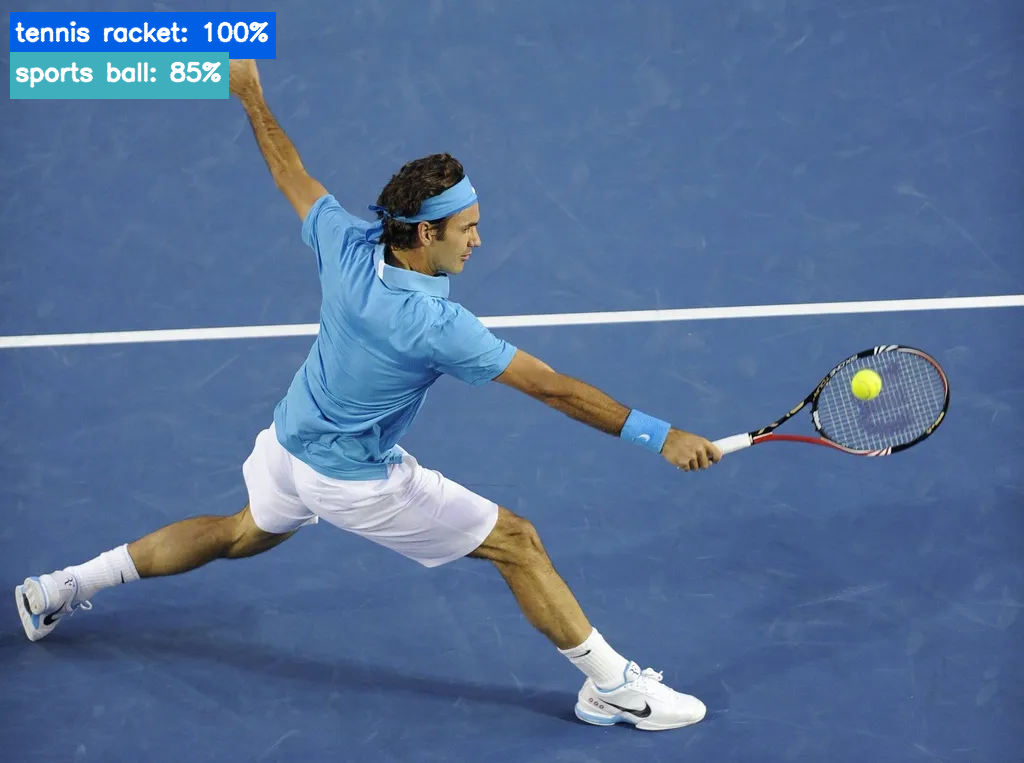

In [3]:
import os

from PIL import Image

from focoos import ASSETS_DIR, RuntimeType

image_size = 96  # 96px input size

exported_model = model.export(
    runtime_type=RuntimeType.ONNX_CPU,  # optimized for edge or cpu
    image_size=image_size,
    dynamic_axes=False,  # quantization need static axes!
    simplify_onnx=True,  # simplify and optimize onnx model graph
    onnx_opset=18,
    out_dir=os.path.join("export/"),
)  # save to models dir

# benchmark onnx model
exported_model.benchmark(iterations=100)

# test onnx model
im = ASSETS_DIR / "federer.jpg"
result = exported_model.infer(im, annotate=True,threshold=0.65)
Image.fromarray(result.image)

## Quantize exported model to int8 (or uint8)

In [4]:
from focoos.infer.quantizer import OnnxQuantizer, QuantizationCfg

quantization_cfg = QuantizationCfg(
    size=image_size,  # input size: must be same as exported model
    calibration_images_folder=str("./calibration"),  # Calibration images folder: It is strongly recommended
    # to use the dataset validation split on which the model was trained.
    # Here, for example, we will use the assets folder.
    format="QO",  # QO (QOperator): All the quantized operators have their own ONNX definitions, like QLinearConv, MatMulInteger etc.
    # QDQ (Quantize-DeQuantize): inserts DeQuantizeLinear(QuantizeLinear(tensor)) between the original operators to simulate the quantization and dequantization process.
    per_channel=False,  # Per-channel quantization: each channel has its own scale/zero-point → more accurate,
    # especially for convolutions, at the cost of extra memory and computation.
    normalize_images=True,  # normalize images during preprocessing: some models have normalization outside of model forward
)

quantizer = OnnxQuantizer(input_model_path=exported_model.model_path, cfg=quantization_cfg)
model_path = quantizer.quantize(
    benchmark=True  # benchmark bot fp32 and int8 models
)

[10/04 18:06][INFO][OnnxQuantizer]: Setting up data reader with calibration images: ./calibration
[10/04 18:06][INFO][onnxruntime.quantization.shape_inference]: Performing symbolic shape inference...


Input shape: 96, 96


[10/04 18:06][INFO][OnnxQuantizer]: 🔧 Quantizing model from export/model.onnx to export/model_int8.onnx
[10/04 18:06][INFO][OnnxQuantizer]: ✅ Quantized model saved successfully to export/model_int8.onnx
[10/04 18:06][INFO][OnnxQuantizer]: ================== BENCHMARKING FP32 MODEL ==================
[10/04 18:06][DEBUG][InferModel]: Runtime type: onnx_cpu, Loading model from export/model.onnx..
[10/04 18:06][DEBUG][ONNXRuntime]: 🔧 [onnxruntime device] CPU
[10/04 18:06][DEBUG][ONNXRuntime]: Available providers:['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']
[10/04 18:06][INFO][ONNXRuntime]:  using: CPUExecutionProvider
[10/04 18:06][INFO][ONNXRuntime]: ⏱️ Warming up model model on CPUExecutionProvider, size: 96x96..
[10/04 18:06][WARNING][focoos.utils.system]: nvidia-smi command not found: [Errno 2] No such file or directory: 'nvidia-smi'
[10/04 18:06][INFO][ONNXRuntime]: ⏱️ Benchmarking latency on arm, size: (96, 96)..
[10/04 18:06][INFO][ONNXRuntime]: 🔥 F

## Inference with quantized model on cpu

[10/04 18:06][DEBUG][InferModel]: Runtime type: onnx_cpu, Loading model from export/model_int8.onnx..
[10/04 18:06][DEBUG][ONNXRuntime]: 🔧 [onnxruntime device] CPU
[10/04 18:06][DEBUG][ONNXRuntime]: Available providers:['CoreMLExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']
[10/04 18:06][INFO][ONNXRuntime]:  using: CPUExecutionProvider
[10/04 18:06][INFO][ONNXRuntime]: ⏱️ Warming up model model_int8 on CPUExecutionProvider, size: 96x96..



1 bird, 1 sports ball, 1 tennis racket
Latency: imload 4ms, preprocess 1ms, inference 1ms, postprocess 0ms, annotate 3ms, total 9ms


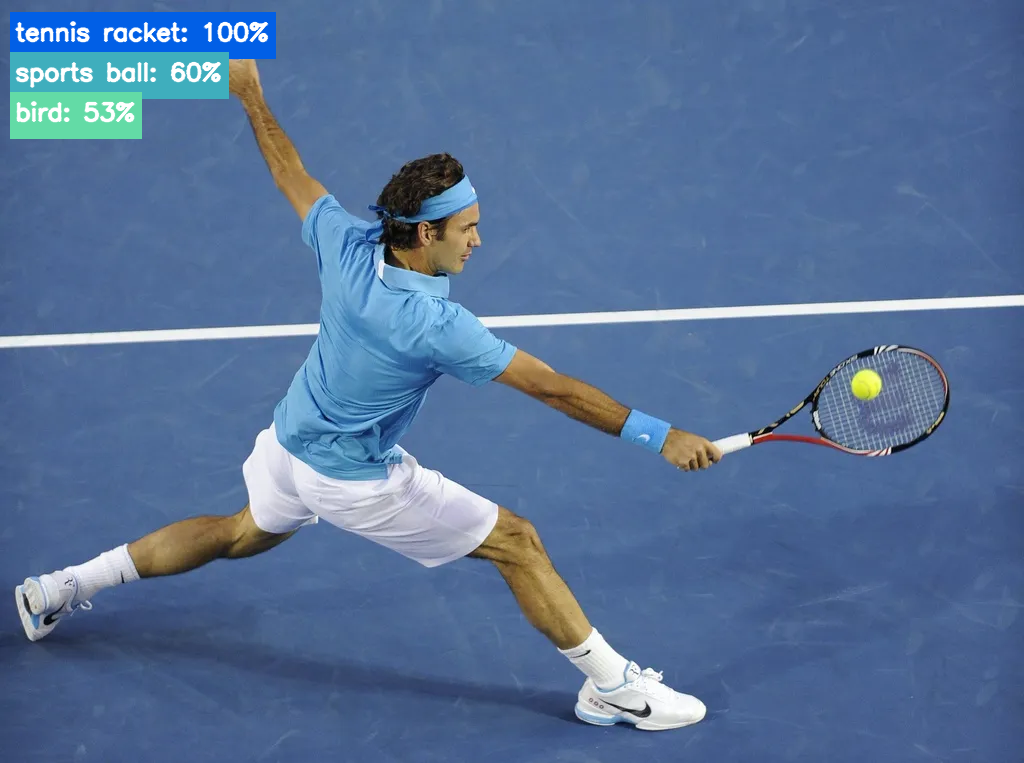

In [5]:
from focoos import InferModel

quantized_model = InferModel(model_path, runtime_type=RuntimeType.ONNX_CPU)

res = quantized_model.infer(im, annotate=True)
Image.fromarray(res.image)

# Train a model from scratch with FocoosAI HUB
👋 Welcome to FocoosAI!

[Create your free account](https://app.focoos.ai/) on the FocoosAI platform and get access to:

- **10 hours of GPU cloud training** 
- **5GB of cloud storage** for your datasets and models
- **1000 cloud inference requests** to test your models
- **Up to 20 models** to experiment with

Start building amazing computer vision models today with our generous free tier!

## Uplaod a dataset

The first step in a computer vision pipeline always starts with data. 
You can use a dataset shared by FocoosAI or upload your own.

You can also find some classification dataset on [Roboflow Universe](https://universe.roboflow.com/search?q=classification) or just create your own with some scraping!

The supported classification dataset layout are:
- **classification folder** (*'folder structure'* on roboflow):

```bash
root/
    train/
        cls1/
            - img_1.jpg
            - img_2.jpg
        cls2/
            - img_1.jpg
            - img_2.jpg
    valid/
        cls1/
            - img_1.jpg
            - img_2.jpg
        cls2/
            img_1.jpg
            img_2.jpg
```
- **roboflow_coco** (*'COCO'* on roboflow):
```bash
root/
    train/
        - _annotations.coco.json
        - img_1.jpg
        - img_2.jpg
    valid/
        - _annotations.coco.json
        - img_3.jpg
        - img_4.jpg
```

First, you need to compress your dataset in .zip format and upload on focoos platform in few clicks:

- go to the dataset page and click on  **"+ add dataset"**, chouse your dataset and upload:

![New Dataset](https://i.imgur.com/2zwPs8d.png)
![Uploading](https://i.imgur.com/7GmwOzW.png)

- Once the upload is finished, you can view a summary, preview, and statistics of your dataset:

![Dataset Info](https://i.imgur.com/qXHFXtU.png) 

## Train a model
- Now we can finally train a model with this dataset, just click on **"Use for training a new model"** and insert name and description about your model:

![New Model](https://i.imgur.com/Io5f4E6.png)

- Configure the hyperparameters, with a recommended batch size of 128 and a resolution of 96px, then initiate the training process:

![Hyperparameters](https://i.imgur.com/NIb5Dq4.png)

- While training, you can monitor the accuracy and loss metrics:

![training](https://i.imgur.com/EX3BXti.png)

- Once training is finished, you can perform inference directly in the browser to evaluate results:

![Inference](https://i.imgur.com/xcHIWv0.png)

- If you are not satisfied with the results, you can train another model with different hyperparameters and compare the models in the “compare models” section.

- Otherwise, you can go to the code snippet section and copy the code to download it to the SDK:

![Code Snippet](https://i.imgur.com/Ju7RgFn.png)